In [10]:
# Standard libraries
import numpy as np
import json
from datetime import datetime

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

# Own library
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
IBM_TOKEN = "56ce0886112e6a0e86ea8eb83e379902e1616cb99deb2ca3505aff78cabeece4757dd9a3e7589dbe9506a643f1876dbf78c2a3444c7a8be123ba413870a11060"


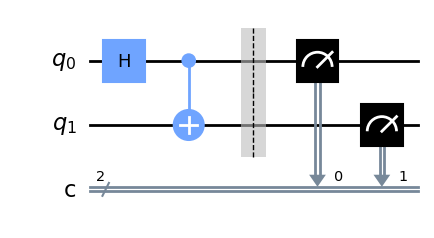

In [11]:
circ = QuantumCircuit(2,2)
circ.h(0)
circ.cx(0,1)

circ.barrier(range(2))
circ.measure(range(2),range(2))
circ.draw('mpl')


In [15]:
config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": "ibmq_kyoto"
    },
    "run": {
        "shots": 1000,
        "qubits_layout": [0, 1],
        "psi0": [1, 0, 0, 0]
    }
}

In [12]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider(token=IBM_TOKEN)

In [13]:
print(provider.backends())

[<IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>]


In [16]:
#backend_config = config["backend"]
#backend = setup_backend(Token=IBM_TOKEN, **backend_config)

backend = provider.get_backend('ibm_kyoto')

run_config = config["run"]

In [17]:

""" Load device parameters from the IBM backend. """

qubits_layout = [0,1]
nr_of_qubits = len(qubits_layout)

# Load
prop = backend.properties()
config = backend.configuration()
defaults = backend.defaults()


In [56]:


T1 = [prop.t1(j) for j in qubits_layout]
T2 = [prop.t2(j) for j in qubits_layout]
p = [prop.gate_error('x', [j]) for j in qubits_layout]
rout = [prop.readout_error(j) for j in qubits_layout]
dt = [backend.configuration().dt]
tm = [prop.readout_length(j) for j in qubits_layout]
metadata = {
            "version": datetime.today().strftime('%Y%m%d'),
            "device": config.backend_name,
            "qubits": config.n_qubits,
            "qubits_layout": qubits_layout,
            "config": config.to_dict()
}


t_ecr = np.zeros((nr_of_qubits, nr_of_qubits))
p_ecr = np.zeros((nr_of_qubits, nr_of_qubits))




In [58]:

if nr_of_qubits > 1:
            for i in range(nr_of_qubits):
                if i == 0:
                    t_ecr[0][1] = prop.gate_length('ecr', [qubits_layout[1], qubits_layout[0]])
                    p_ecr[0][1] = prop.gate_error('ecr', [qubits_layout[1], qubits_layout[0]])
                if i != 0 and i != nr_of_qubits-1:
                    t_ecr[i][i-1] = prop.gate_length('ecr', [qubits_layout[i-1], qubits_layout[i]])
                    p_ecr[i][i-1] = prop.gate_error('ecr', [qubits_layout[i-1], qubits_layout[i]])
                    t_ecr[i][i+1] = prop.gate_length('ecr', [qubits_layout[i+1], qubits_layout[i]])
                    p_ecr[i][i+1] = prop.gate_error('ecr', [qubits_layout[i+1], qubits_layout[i]])
                if i == nr_of_qubits-1:
                    t_ecr[i][i-1] = prop.gate_length('ecr', [qubits_layout[i-1], qubits_layout[i]])
                    p_ecr[i][i-1] = prop.gate_error('ecr', [qubits_layout[i-1], qubits_layout[i]])
t_ecr = t_ecr
p_ecr = p_ecr

BackendPropertyError: 'Could not find the desired property for ecr'

In [ ]:
qubits_layout = run_config["qubits_layout"]
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()

In [104]:
sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

t_circ = transpile(
    circ,
    backend,
    scheduling_method='asap',
    initial_layout=qubits_layout,
    seed_transpiler=42
)


In [98]:

probs = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(run_config["psi0"]), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=2)

counts_ng = {format(i, 'b').zfill(2): probs[i] for i in range(0, 4)}

TypeError: run() missing 1 required positional argument: 'device_param'

In [ ]:
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])